In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0)

## 1) SwiGLU 简介

SwiGLU 是 **Swish 激活函数 + GLU 门控线性单元** 的组合，是 LLM 中最常用的 Feed-Forward 架构之一。

**传统 FFN**: `FFN(x) = W2 * Act(W1 * x)`

**SwiGLU**: `SwiGLU(x) = (W1 * x) ⊙ (Act(W2 * x))` → `W3 * output`

其中 ⊙ 表示逐元素乘法，Act 通常是 **SiLU/Swish**：`silu(x) = x * sigmoid(x)`

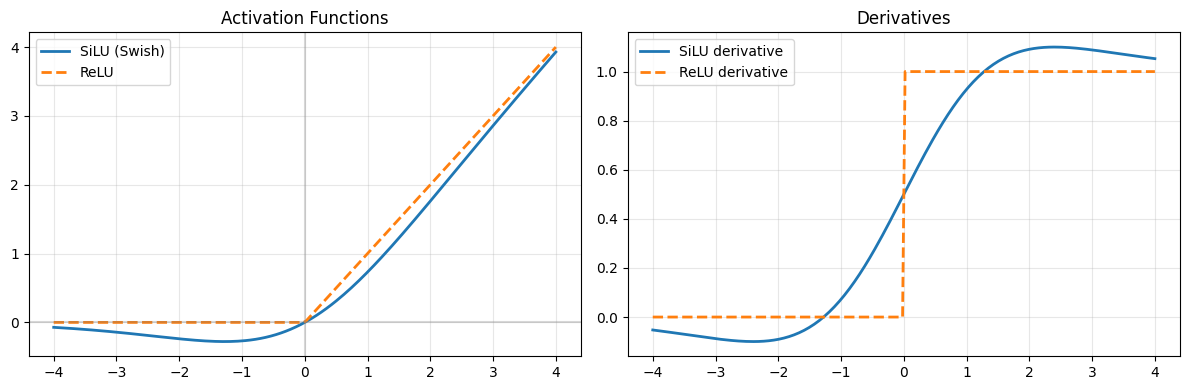

In [6]:
def silu(x):
    """SiLU / Swish activation: x * sigmoid(x)"""
    return x * torch.sigmoid(x)

x = torch.linspace(-4, 4, 200)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x.numpy(), silu(x).numpy(), label="SiLU (Swish)", linewidth=2)
plt.plot(x.numpy(), torch.relu(x).numpy(), label="ReLU", linewidth=2, linestyle="--")
plt.axhline(0, color="gray", alpha=0.3)
plt.axvline(0, color="gray", alpha=0.3)
plt.title("Activation Functions")
plt.legend()
plt.grid(True, alpha=0.3)

# SiLU derivative: silu'(x) = silu(x) + sigmoid(x) * (1 - silu(x))
silu_derivative = silu(x) + torch.sigmoid(x) * (1 - silu(x))
relu_derivative = (x > 0).float()

plt.subplot(1, 2, 2)
plt.plot(x.numpy(), silu_derivative.detach().numpy(), label="SiLU derivative", linewidth=2)
plt.plot(x.numpy(), relu_derivative.numpy(), label="ReLU derivative", linewidth=2, linestyle="--")
plt.title("Derivatives")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2) GLU 门控机制

GLU (Gated Linear Unit) 的核心思想：
1. 用 `gate_proj` 线性变换生成门控信号
2. 对门控信号应用激活函数后，与 `up_proj` 的输出做逐元素乘法
3. 最后用 `down_proj` 投影回原维度

数学表达式：
$$
\text{SwiGLU}(x) = W_3 \left( (W_1 x) \odot \text{SiLU}(W_2 x) \right)
$$

In [7]:
class FeedForward(nn.Module):
    """SwiGLU Feed Forward Network"""
    def __init__(self, hidden_size: int, intermediate_size: int = None, dropout: float = 0.1):
        super().__init__()
        if intermediate_size is None:
            intermediate_size = int(hidden_size * 8 / 3)
            intermediate_size = 64 * ((intermediate_size + 64 - 1) // 64)
        
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.down_proj(silu(self.gate_proj(x)) * self.up_proj(x)))

# 参数统计
hidden_size = 4096
ffn = FeedForward(hidden_size=hidden_size)

gate_params = sum(p.numel() for p in ffn.gate_proj.parameters())
up_params = sum(p.numel() for p in ffn.up_proj.parameters())
down_params = sum(p.numel() for p in ffn.down_proj.parameters())
total_params = gate_params + up_params + down_params

print(f"hidden_size: {hidden_size}")
print(f"intermediate_size: {ffn.intermediate_size}")
print(f"gate_proj: {gate_params:,} ({gate_params/1e6:.2f}M)")
print(f"up_proj: {up_params:,} ({up_params/1e6:.2f}M)")
print(f"down_proj: {down_params:,} ({down_params/1e6:.2f}M)")
print(f"total: {total_params:,} ({total_params/1e6:.2f}M)")

hidden_size: 4096
intermediate_size: 10944
gate_proj: 44,826,624 (44.83M)
up_proj: 44,826,624 (44.83M)
down_proj: 44,826,624 (44.83M)
total: 134,479,872 (134.48M)


## 3) 为什么 SwiGLU 效果好？

### 3.1 门控机制的优势
- SiLU 作为门控输出范围约 (-0.28, ∞)
- 负值可以抑制某些特征通道，正值可以增强某些特征
- 相比 ReLU 的硬截断，SiLU 更平滑，梯度更稳定

### 3.2 逐元素乘法的信息交互
- `gate * up` 让两个不同的线性变换结果相互作用
- 相当于一种自适应特征选择机制

### 3.3 参数量与计算量的权衡
- SwiGLU 比传统 FFN 多一个投影，但中间层更大
- LLaMA 等模型选择 intermediate_size ≈ hidden_size * 8/3

输入形状: torch.Size([2, 10, 4096])
Gate 输出形状: torch.Size([2, 10, 10944])
Up 输出形状: torch.Size([2, 10, 10944])
门控后形状: torch.Size([2, 10, 10944])
最终输出形状: torch.Size([2, 10, 4096])

门控激活统计:
  均值: 0.0775
  标准差: 0.3071
  最小值: -0.2785
  最大值: 2.3290
  负值比例: 50.04%


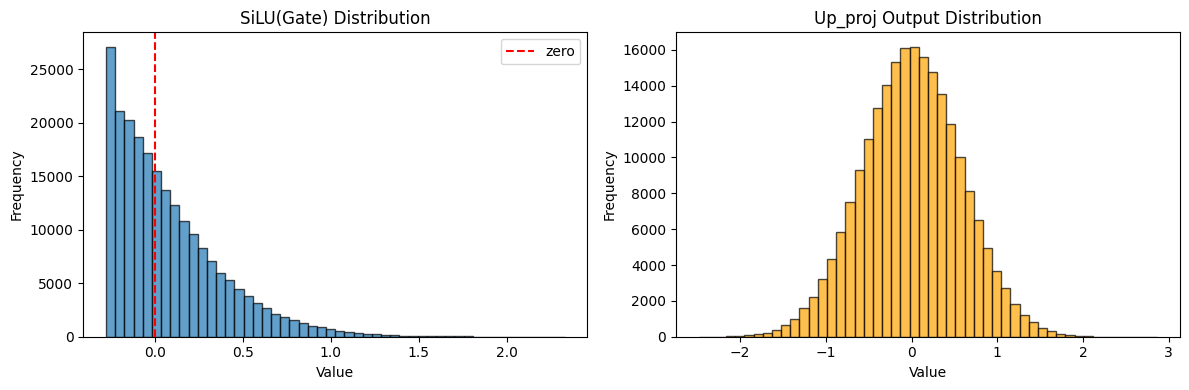

In [10]:
# 可视化门控效果
batch_size, seq_len, hidden_size = 2, 10, 4096

x = torch.randn(batch_size, seq_len, hidden_size)

gate = ffn.gate_proj(x)
gate_activated = silu(gate)
up = ffn.up_proj(x)
gated = gate_activated * up
output = ffn.down_proj(gated)

print(f"输入形状: {x.shape}")
print(f"Gate 输出形状: {gate.shape}")
print(f"Up 输出形状: {up.shape}")
print(f"门控后形状: {gated.shape}")
print(f"最终输出形状: {output.shape}")

print(f"\n门控激活统计:")
print(f"  均值: {gate_activated.mean().item():.4f}")
print(f"  标准差: {gate_activated.std().item():.4f}")
print(f"  最小值: {gate_activated.min().item():.4f}")
print(f"  最大值: {gate_activated.max().item():.4f}")
print(f"  负值比例: {(gate_activated < 0).float().mean().item():.2%}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(gate_activated.flatten().detach().cpu().numpy(), bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='zero')
plt.title("SiLU(Gate) Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(up.flatten().detach().cpu().numpy(), bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("Up_proj Output Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 4) 梯度流分析

对比传统 FFN (ReLU) 与 SwiGLU 的梯度流动情况。

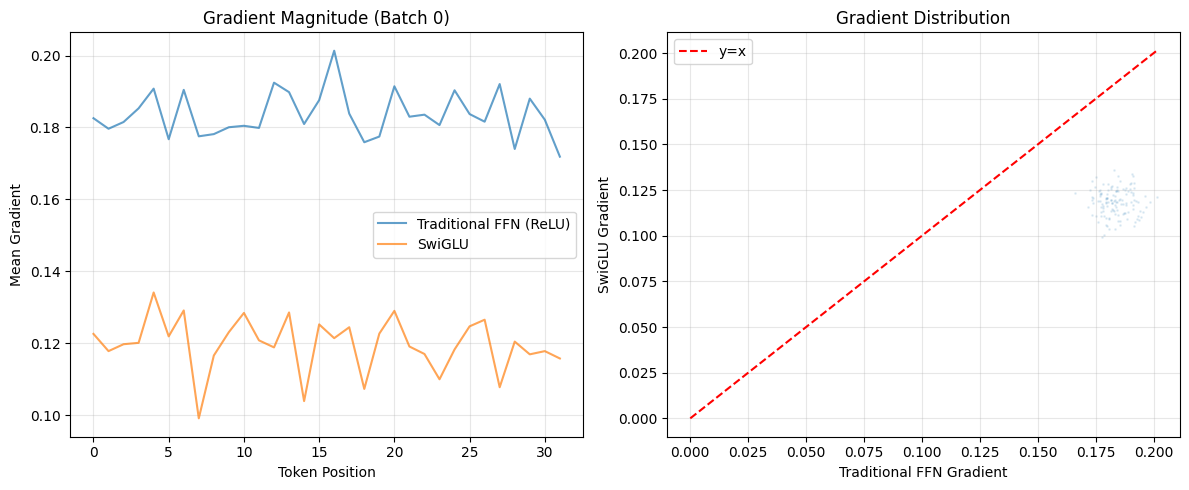

传统 FFN 平均梯度: 0.183620
SwiGLU 平均梯度: 0.118423


In [13]:
class TraditionalFFN(nn.Module):
    """传统 FFN: ReLU(W2(W1 x))"""
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.w1 = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.w2 = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.act = nn.ReLU()
        
    def forward(self, x):
        return self.w2(self.act(self.w1(x)))

class SwiGLUFFN(nn.Module):
    """SwiGLU FFN"""
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        
    def forward(self, x):
        return self.down_proj(silu(self.gate_proj(x)) * self.up_proj(x))

hidden_size = 512
intermediate_size = 2048

ffn_trad = TraditionalFFN(hidden_size, intermediate_size)
ffn_swiglu = SwiGLUFFN(hidden_size, intermediate_size)

x = torch.randn(4, 32, hidden_size, requires_grad=True)


x_trad = x.clone().detach().requires_grad_(True) 

y_trad = ffn_trad(x_trad)
loss_trad = y_trad.sum()
loss_trad.backward()

grad_trad = x_trad.grad.abs().mean(dim=-1)

# SwiGLU 梯度
x_swiglu = x.clone().detach().requires_grad_(True) 
y_swiglu = ffn_swiglu(x_swiglu)
loss_swiglu = y_swiglu.sum()
loss_swiglu.backward()
grad_swiglu = x_swiglu.grad.abs().mean(dim=-1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(grad_trad[0].detach().cpu().numpy(), label="Traditional FFN (ReLU)", alpha=0.7)
plt.plot(grad_swiglu[0].detach().cpu().numpy(), label="SwiGLU", alpha=0.7)
plt.title("Gradient Magnitude (Batch 0)")
plt.xlabel("Token Position")
plt.ylabel("Mean Gradient")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(grad_trad.flatten().detach().cpu().numpy(), 
            grad_swiglu.flatten().detach().cpu().numpy(), alpha=0.1, s=1)
plt.plot([0, grad_trad.max()], [0, grad_trad.max()], 'r--', label="y=x")
plt.xlabel("Traditional FFN Gradient")
plt.ylabel("SwiGLU Gradient")
plt.title("Gradient Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"传统 FFN 平均梯度: {grad_trad.mean().item():.6f}")
print(f"SwiGLU 平均梯度: {grad_swiglu.mean().item():.6f}")

## 5) 代码实现对比

对比两种 SwiGLU 的实现方式：nn.Module 和 F.silu。

In [14]:
class PyTorchSwiGLU(nn.Module):
    """PyTorch 实现"""
    def __init__(self, hidden_size: int, intermediate_size: int):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.silu = nn.SiLU()
        
    def forward(self, x):
        return self.down_proj(self.silu(self.gate_proj(x)) * self.up_proj(x))

import torch.nn.functional as F

class FSwiGLU(nn.Module):
    """F.silu 实现"""
    def __init__(self, hidden_size: int, intermediate_size: int):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        
    def forward(self, x):
        return F.silu(self.gate_proj(x)) * self.up_proj(x) @ self.down_proj.weight.t()

hidden_size = 256
intermediate_size = 512

model1 = PyTorchSwiGLU(hidden_size, intermediate_size)
model2 = FSwiGLU(hidden_size, intermediate_size)

model2.gate_proj.weight.data = model1.gate_proj.weight.data.clone()
model2.up_proj.weight.data = model1.up_proj.weight.data.clone()
model2.down_proj.weight.data = model1.down_proj.weight.data.clone()

x = torch.randn(2, 10, hidden_size)
y1 = model1(x)
y2 = model2(x)

print(f"PyTorch 输出形状: {y1.shape}")
print(f"F.silu 输出形状: {y2.shape}")
print(f"输出差异: {(y1 - y2).abs().max().item():.2e}")

PyTorch 输出形状: torch.Size([2, 10, 256])
F.silu 输出形状: torch.Size([2, 10, 256])
输出差异: 0.00e+00


## 6) 总结

### SwiGLU 的核心特点
1. **门控机制**: SiLU 作为软门控，比 ReLU 更平滑
2. **逐元素交互**: gate * up 实现特征自适应选择
3. **参数效率**: 3个投影，中间层更大（LLaMA: 8/3倍）
4. **梯度流**: 负值区域允许梯度流动，减少死神经元

### 实际应用
- LLaMA, PaLM, Mistral 等主流 LLM 都采用 SwiGLU
- 中间层大小通常是 hidden_size 的 8/3 倍，向上取整到 64 的倍数